# Fitting the H.E.S.S. Crab spectrum with iminuit and emcee

As an example of a chi^2 fit, we use the flux points from the Crab nebula
as measured by H.E.S.S. in 2006:  http://adsabs.harvard.edu/abs/2006A%26A...457..899A

In [46]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import astropy.units as u

## The data

We start by loading the flux points from a text file.

It is of course possible to load this data using just Python
or Numpy, but we'll use the [pandas.read_table](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_table.html) function
because it's very flexible, i.e. by setting a few arguments you'll
be able to load most ascii tables.

**EDIT: Now I will try to replace the pandas data table with Gammapy's FluxPoints class. I will select the source 3FGL J1459.4-6053.**

In [6]:
from gammapy.catalog import SourceCatalog3FGL, SourceCatalogObject3FGL

cat = SourceCatalog3FGL()
source = cat['3FGL J1459.4-6053']
# source = cat['3FGL J0534.5+2201i'] # crab
data = source.flux_points.table

# Convert flux data from TeV to MeV
data['dnde'] = data['dnde'].to('cm-2 s-1 MeV-1')

# Create dnde_err property because it doesn't exist (yet) in table data
dnde_err = data['dnde'] * (data['flux_errn'] / data['flux'])
data['dnde_err'] = dnde_err.to(data['dnde'].unit)


data.info()
# data.show_in_browser()

<Table length=5>
   name     dtype        unit     
---------- ------- ---------------
     e_ref float64             MeV
     e_min float64             MeV
     e_max float64             MeV
      flux float32     1 / (cm2 s)
 flux_errn float32     1 / (cm2 s)
 flux_errp float32     1 / (cm2 s)
     eflux float32   erg / (cm2 s)
eflux_errn float32   erg / (cm2 s)
eflux_errp float32   erg / (cm2 s)
      dnde float64 1 / (cm2 MeV s)
  dnde_err float64 1 / (cm2 MeV s)


In [33]:
cols = ['e_ref', 'dnde', 'dnde_err']
data[cols]

e_ref,dnde,dnde_err
MeV,1 / (cm2 MeV s),1 / (cm2 MeV s)
float64,float64,float64
173.205080757,6.49591659276e-10,1.06823212212e-10
547.722557505,6.70232016236e-11,4.80963380543e-12
1732.05080757,5.21379369508e-12,2.53808176338e-13
5477.22557505,1.86889846596e-13,1.5992033305e-14
31622.7766017,2.85186831677e-16,1.26925782458e-16


In [25]:
pprint(source.spectral_model.parameters) # Declared as var "p" below

{'amplitude': <Quantity 1.545281264059284e-11 1 / (cm2 MeV s)>,
 'ecut': <Quantity 3130.83056640625 MeV>,
 'index': <Quantity 1.8699387311935425>,
 'reference': <Quantity 1085.46142578125 MeV>}


In [12]:
print(source.energy_range)

[    100.  100000.] MeV


## The model

In the paper they fit a power-law with an exponential cutoff and find the following parameters (see row "all" in table 6):
* gamma = 2.39 +- 0.03
* energy_cut = 14.3 +- 2.1 TeV
* flux1 = (3.76 +- 0.07) x 1e-11 cm^-2 s^-1 TeV^-1

The flux1 is the differential flux at 1 TeV.

Let's code up that model ...


TODO: extend this tutorial to also consider a power-law model and compare the two models via chi2 / ndf.

In [35]:
def flux_ecpl(energy, flux1, gamma, energy_cut):
    return flux1 * energy ** (-gamma) * np.exp(-energy / energy_cut)

## Plot data and model

Let's plot the data and model and compare to Figure 18b
from the paper ...

<Container object of 3 artists>

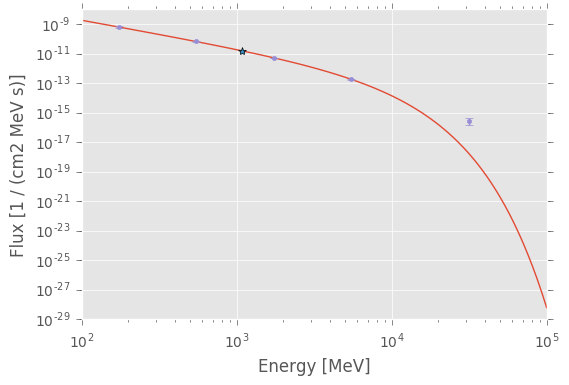

In [64]:
opts = dict(energy_unit='MeV', flux_unit='cm-2 s-1 MeV-1') # Energy units

# Plot the red line curve
source.spectral_model.plot(source.energy_range, **opts)
# ^ What exactly is this?

p = source.spectral_model.parameters
e_ref = p['reference']

# Plot a reference point
plt.plot(e_ref.value, p['amplitude'].value, "*")

# Plot all data from source flux_points attribute and errorbar
plt.errorbar(x=data['e_ref'],
             y=data['dnde'],
             yerr=data['dnde_err'],
             fmt='.'
            )

# The likelihood

In this case we'll use a chi^2 likelihood function to
fit the model to the data.

Note that the likelihood function combines the data and model, and just depends on the model parameters that
shall be estimated (whereas the model function `flux_ecpl` has an extra parameter `energy`).

Also note that we're accessing `data` and model `flux_ecpl` from the global scope instead of passing them in explicitly as parameters. Modeling and fitting frameworks like e.g. Sherpa have more elaborate ways to combine data and models and likelihood functions, but for simple, small code examples like we do here, using the global scope to tie things together works just fine.

In [62]:
source.spectral_model(e_ref)

<Quantity 1.545281264059284e-11 1 / (cm2 MeV s)>

In [56]:
# The same model as defined in Gammapy
def dnde_model_ecpl(energy, amplitude, index, energy_cut, reference):
    return amplitude * (energy / reference) ** (-index) * np.exp((reference -energy) / energy_cut)


# Defining chi2 function for this source
def chi2(amplitude, index, energy_cut):
    
    dnde_model = dnde_model_ecpl(
        energy=data['e_ref'],
        amplitude=amplitude,
        index=index,
        energy_cut=energy_cut,
        reference=1085.46142578125 # <-- this is e_ref minus the units
    ) 
    
    chi = (data['dnde'] - dnde_model) / data['dnde_err']
    return np.sum(chi ** 2)

In [57]:
# Test one example evaluation to get same result as "source.spectral_model"
dnde_model_ecpl(
    energy=1085.46142578125,
    amplitude=1.545281264059284e-11,
    index=1.8699387311935425,
    energy_cut=3130.83056640625,
    reference=1085.46142578125
)

1.5452812640592839e-11

In [ ]:
# I would want to implement come Chi2Fitter class here - see other notebook
# for more details.

## ML fit with Minuit

Let's use Minuit to do a maximum likelihood (ML) analysis.

Note that this is not what they did in the paper (TODO: check), so it's not surprising if best-fit results
are a little different.

In [59]:
from iminuit import Minuit

# parameters from example evaluation
pars = dict(amplitude=1.545281264059284e-11,
            index=1.8699387311935425,
            energy_cut=3130.83056640625
           )

m = Minuit(chi2, **pars)
m.migrad()

C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: InitialParamWarning: errordef is not given. Default to 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: InitialParamWarning: Parameter energy_cut is floating but does not have initial step size. Assume 1.


FCN = 4.993143110998093 
 TOTAL NCALL = 70 
 NCALLS = 70 
 
 
 EDM = 5.946373855365906e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,1.54312e-11,1.63009e-12,0,0,,,
2,index,1.89632,0.147375,0,0,,,
3,energy_cut,3270.3,1121.69,0,0,,,


({'fval': 4.993143110998093, 'has_made_posdef_covar': False, 'edm': 5.946373855365906e-06, 'up': 1.0, 'hesse_failed': False, 'is_valid': True, 'has_covariance': True, 'nfcn': 70, 'has_posdef_covar': True, 'has_accurate_covar': True, 'is_above_max_edm': False, 'has_reached_call_limit': False, 'has_valid_parameters': True},
 [{'name': 'amplitude', 'is_fixed': False, 'has_limits': False, 'upper_limit': 0.0, 'number': 0, 'value': 1.5431202012237844e-11, 'has_upper_limit': False, 'is_const': False, 'lower_limit': 0.0, 'error': 1.630086529958188e-12, 'has_lower_limit': False},
  {'name': 'index', 'is_fixed': False, 'has_limits': False, 'upper_limit': 0.0, 'number': 1, 'value': 1.896317192430001, 'has_upper_limit': False, 'is_const': False, 'lower_limit': 0.0, 'error': 0.1473749242023529, 'has_lower_limit': False},
  {'name': 'energy_cut', 'is_fixed': False, 'has_limits': False, 'upper_limit': 0.0, 'number': 2, 'value': 3270.3013373674416, 'has_upper_limit': False, 'is_const': False, 'lower_l

In [60]:
print(m.values)
print(m.errors)

{'energy_cut': 3270.3013373674416, 'amplitude': 1.5431202012237844e-11, 'index': 1.896317192430001}
{'energy_cut': 1121.6924916304022, 'amplitude': 1.630086529958188e-12, 'index': 0.1473749242023529}
